In [0]:
import numpy as np
import pandas as pd 

In [2]:
from google.colab import files
uploaded = files.upload()

Saving all.csv to all (2).csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['all.csv']))

In [4]:
df.head()

,author,content,poem name,age,type
0,WILLIAM SHAKESPEARE,Let the bird of loudest lay\r\nOn the sole Ara...,The Phoenix and the Turtle,Renaissance,Mythology & Folklore
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,"Sir Charles into my chamber coming in,\r\nWhen...",An Epilogue to the Above,Renaissance,Mythology & Folklore
2,THOMAS BASTARD,"Our vice runs beyond all that old men saw,\r\n...","Book 7, Epigram 42",Renaissance,Mythology & Folklore
3,EDMUND SPENSER,"Lo I the man, whose Muse whilome did maske,\r\...","from The Faerie Queene: Book I, Canto I",Renaissance,Mythology & Folklore
4,RICHARD BARNFIELD,"Long have I longd to see my love againe,\r\nSt...",Sonnet 16,Renaissance,Mythology & Folklore


In [0]:
df_modern = df[df['age'] == 'Modern']

In [6]:
df_modern.head()

,author,content,poem name,age,type
315,EDGAR LEE MASTERS,"I leaned against the mantel, sick, sick,\r\nTh...",Harold Arnett,Modern,Mythology & Folklore
316,EDGAR LEE MASTERS,I was the first fruits of the battle of Missio...,Knowlt Hoheimer,Modern,Mythology & Folklore
317,EDGAR LEE MASTERS,I was only eight years old;\r\nAnd before I gr...,Nellie Clark,Modern,Mythology & Folklore
318,WILLIAM BUTLER YEATS,"W. B. Yeats, Lapis Lazuli from The Poems of W....",Lapis Lazuli,Modern,Mythology & Folklore
319,WILLIAM BUTLER YEATS,Why should I blame her that she filled my days...,No Second Troy,Modern,Mythology & Folklore


In [0]:
df = df[pd.notnull(df['content'])]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258 entries, 315 to 572
Data columns (total 5 columns):
author       258 non-null object
content      258 non-null object
poem name    256 non-null object
age          258 non-null object
type         258 non-null object
dtypes: object(5)
memory usage: 12.1+ KB


In [0]:
col = ['type', 'content']
df = df[col]

In [13]:
df.columns

Index(['type', 'content'], dtype='object')

In [0]:
df.columns = ['type', 'content']

In [0]:
df['category_id'] = df['type'].factorize()[0]
from io import StringIO
category_id_df = df[['type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'type']].values)

In [16]:
df.head()

,type,content,category_id
315,Mythology & Folklore,"I leaned against the mantel, sick, sick,\r\nTh...",0
316,Mythology & Folklore,I was the first fruits of the battle of Missio...,0
317,Mythology & Folklore,I was only eight years old;\r\nAnd before I gr...,0
318,Mythology & Folklore,"W. B. Yeats, Lapis Lazuli from The Poems of W....",0
319,Mythology & Folklore,Why should I blame her that she filled my days...,0


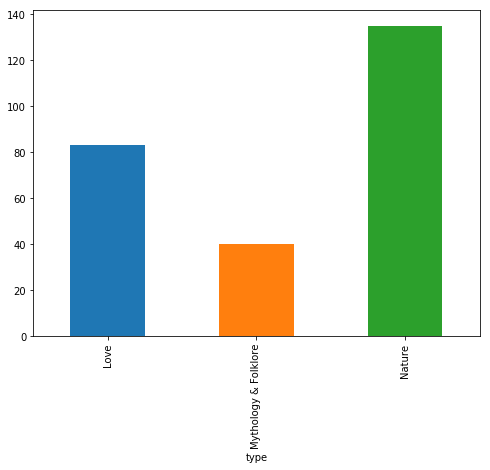

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('type').content.count().plot.bar(ylim=0)
plt.show()

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.content).toarray()
labels = df.category_id
features.shape

(258, 712)

In [21]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Love':
  . Most correlated unigrams:
       . published
       . originally
  . Most correlated bigrams:
       . published poetry
       . originally published
# 'Mythology & Folklore':
  . Most correlated unigrams:
       . ezra
       . pound
  . Most correlated bigrams:
       . pound canto
       . ezra pound
# 'Nature':
  . Most correlated unigrams:
       . pound
       . originally
  . Most correlated bigrams:
       . published poetry
       . originally published


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['content'], df['type'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [24]:
print(clf.predict(count_vect.transform(["The earth is so beautiful, the sky, the water, the greenery"])))

['Nature']


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

In [28]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.581523
LogisticRegression        0.565988
MultinomialNB             0.578054
RandomForestClassifier    0.523303
Name: accuracy, dtype: float64

In [0]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

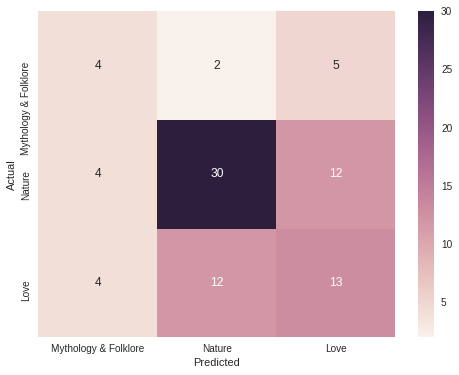

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.type.values, yticklabels=category_id_df.type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [32]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['type'].unique()))

                      precision    recall  f1-score   support

Mythology & Folklore       0.33      0.36      0.35        11
              Nature       0.68      0.65      0.67        46
                Love       0.43      0.45      0.44        29

           micro avg       0.55      0.55      0.55        86
           macro avg       0.48      0.49      0.49        86
        weighted avg       0.55      0.55      0.55        86

